# Libraries 📖

In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import squarify
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
import plotly.express as px
import plotly.graph_objects as go
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import shap

# Database 📂

## Upload Database ⬆️

In [2]:
conn = sqlite3.connect("../data/olist.sqlite")
c = conn.cursor()

In [3]:
# write the query
query = """
SELECT
    or2.review_score,
    op.payment_type,
    op.payment_installments,
    op.payment_value,
    oi.freight_value/oi.price AS freight_weight,
    MAX(oi.order_item_id) AS item_per_order,
    julianday(o.order_delivered_customer_date)- julianday(o.order_approved_at) AS delivery_time,
    gld.distance_km 
FROM orders o
INNER JOIN order_reviews or2 ON or2.order_id = o.order_id 
INNER JOIN order_payments op ON op.order_id = o.order_id
INNER JOIN order_items oi ON oi.order_id = o.order_id
INNER JOIN geo_loc_det gld ON gld.order_id = o.order_id 
WHERE o.order_status == 'delivered'
GROUP BY oi.order_id 
"""
# Execute the query
c.execute(query)
#Fetch and print the results
c.fetchall()
df_ml = pd.read_sql_query(query, conn)

## Clear 🧹

In [4]:
df_ml.isna().sum()

review_score             0
payment_type             0
payment_installments     0
payment_value            0
freight_weight           0
item_per_order           0
delivery_time           22
distance_km              1
dtype: int64

In [5]:
df_ml = df_ml.dropna()
df_ml.isna().sum()

review_score            0
payment_type            0
payment_installments    0
payment_value           0
freight_weight          0
item_per_order          0
delivery_time           0
distance_km             0
dtype: int64

In [6]:
df_ml.shape

(95333, 8)

## Balance ⚖️

In [7]:
df_ml['review_score'].value_counts()

5    56399
4    18806
1     9336
3     7877
2     2915
Name: review_score, dtype: int64

In [8]:
# Define rating_cat as customer satisfaction (1 for yes, 0 for no)
def convert_score(valor):
    if valor < 4:
        return 0
    elif valor >= 4:
        return 1
    
df_ml['review_score'] = df_ml['review_score'].apply(convert_score)
df_ml['review_score'].value_counts()

1    75205
0    20128
Name: review_score, dtype: int64

In [9]:
# Separate majority and minority classes
df_majority = df_ml[df_ml['review_score'] == 1]
df_minority = df_ml[df_ml['review_score'] == 0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # match minority class size
                                   random_state=42)  # for reproducibility

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class distribution
print(df_balanced['review_score'].value_counts())

1    20128
0    20128
Name: review_score, dtype: int64


## Encode ⚙️

In [10]:
%%time
# Encode categorical columns
ohe = OneHotEncoder(sparse_output = False)
ohe.fit(df_balanced[['payment_type']])
df_balanced[ohe.get_feature_names_out()] = ohe.transform(df_balanced[['payment_type']])
df_encoded = df_balanced.drop(columns = ["payment_type"])
df_encoded

CPU times: user 11 ms, sys: 485 µs, total: 11.5 ms
Wall time: 11.1 ms


,review_score,payment_installments,payment_value,freight_weight,item_per_order,delivery_time,distance_km,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
86492,1,1,114.33,0.144444,1,6.771262,219.782200,1.0,0.0,0.0,0.0
49423,1,3,61.64,0.235271,1,8.860220,311.121906,0.0,1.0,0.0,0.0
82818,1,1,33.23,1.215333,1,16.349942,1059.953104,0.0,1.0,0.0,0.0
11099,1,10,876.24,0.032085,1,5.938900,492.816463,0.0,1.0,0.0,0.0
528,1,4,84.32,0.299230,1,14.685359,707.330653,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95329,0,5,166.71,0.112141,1,14.039780,424.749642,0.0,1.0,0.0,0.0
95334,0,3,142.10,0.093161,1,16.875949,38.562497,0.0,1.0,0.0,0.0
95335,0,2,77.70,0.110793,1,1.282824,27.139418,0.0,1.0,0.0,0.0
95337,0,1,50.62,1.025610,1,37.594572,1833.448928,1.0,0.0,0.0,0.0


In [11]:
df_encoded.isna().sum()

review_score                0
payment_installments        0
payment_value               0
freight_weight              0
item_per_order              0
delivery_time               0
distance_km                 0
payment_type_boleto         0
payment_type_credit_card    0
payment_type_debit_card     0
payment_type_voucher        0
dtype: int64

# Data exploration 🔍

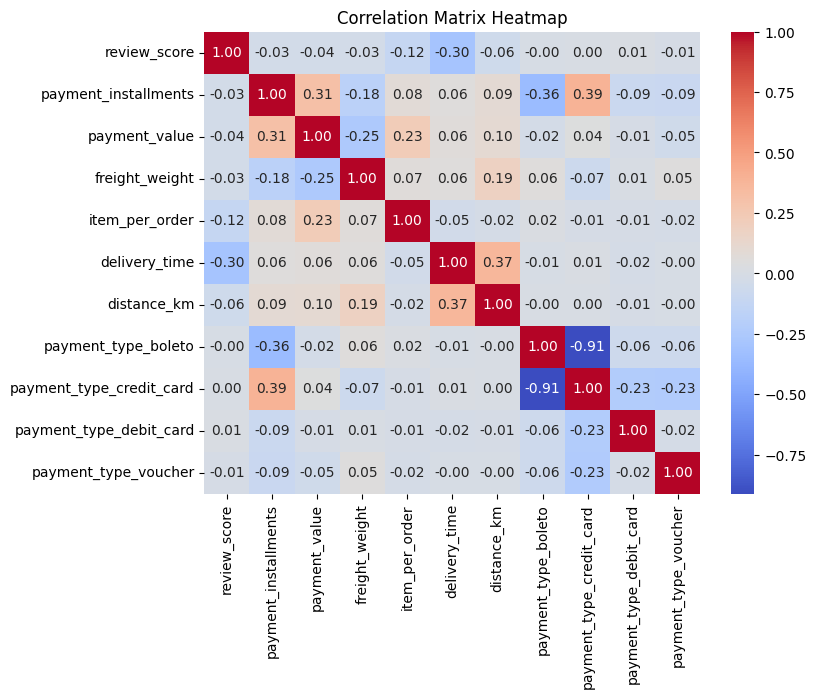

In [12]:
# Plotting the correlation matrix as a heatmap
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Modeling  - RandomForestClassifier 🤖

## Split Database

In [13]:
# # Split data - train and test
X = df_encoded.drop(['review_score'], axis=1)
y = df_encoded['review_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tunning model

In [14]:
# Creation of the random forest model

rf_model = RandomForestClassifier(random_state=42)

### Random Search

In [15]:
# Define the hyperparameter grid
param_dist = {
    'n_estimators': stats.randint(300,600),          # Number of trees in the forest
    'max_depth': [None, 4, 6, 7, 8, 9, 10, 12],       # Maximum depth of the tree
    'min_samples_split': stats.randint(2,20),        # Minimum number of samples required to split an internal node
    'min_samples_leaf': stats.randint(1,10),         # Minimum number of samples required at a leaf node
    'max_features': [None, 'sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'bootstrap': [True, False],                 # Whether to use bootstrap samples when building trees
    'class_weight': [None, 'balanced', 'balanced_subsample']          # Weights associated with classes
}

In [16]:
%%time
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=2,        # Number of folds in cross-validation
    n_jobs=-1,   # Use all available cores
    random_state=42
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print the best score
print(f"Best cross-validation score: {random_search.best_score_}")

Best cross-validation score: 0.6541423425661408
CPU times: user 15.6 s, sys: 250 ms, total: 15.9 s
Wall time: 2min 24s


In [17]:
best_par = random_search.best_params_
rf_model = RandomForestClassifier(**best_par, random_state=42)
best_par

{'bootstrap': True,
 'class_weight': None,
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 495}

In [18]:
%%time
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform cross-validation with 5 folds
cv_results = cross_validate(rf_model, X_train, y_train, cv=2, scoring=scoring, return_train_score=True)

# Output the cross-validation results
print("Cross-Validation Results:")
print(f"Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Test Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Test Recall: {cv_results['test_recall'].mean():.4f}")
print(f"Test F1 Score: {cv_results['test_f1'].mean():.4f}")

Cross-Validation Results:
Train Accuracy: 0.6576
Test Accuracy: 0.6541
Test Precision: 0.6155
Test Recall: 0.8198
Test F1 Score: 0.7031
CPU times: user 15.9 s, sys: 0 ns, total: 15.9 s
Wall time: 15.9 s


## Modeling check

In [19]:
%%time
train_sizes = np.arange(50, 3000, 50, dtype=int)

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model, X=X_train, y=y_train, train_sizes=train_sizes, cv=2)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

CPU times: user 2min 13s, sys: 72.9 ms, total: 2min 13s
Wall time: 2min 13s


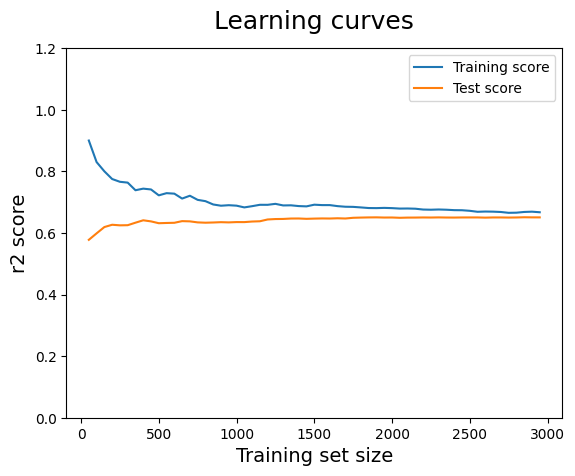

In [20]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.ylim(0,1.2)
plt.legend();

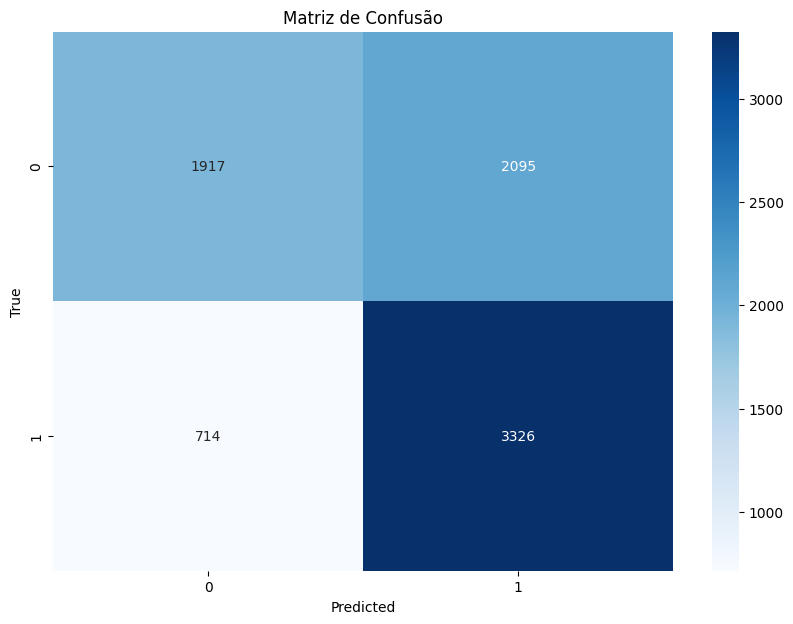

In [21]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

## Feature Importances

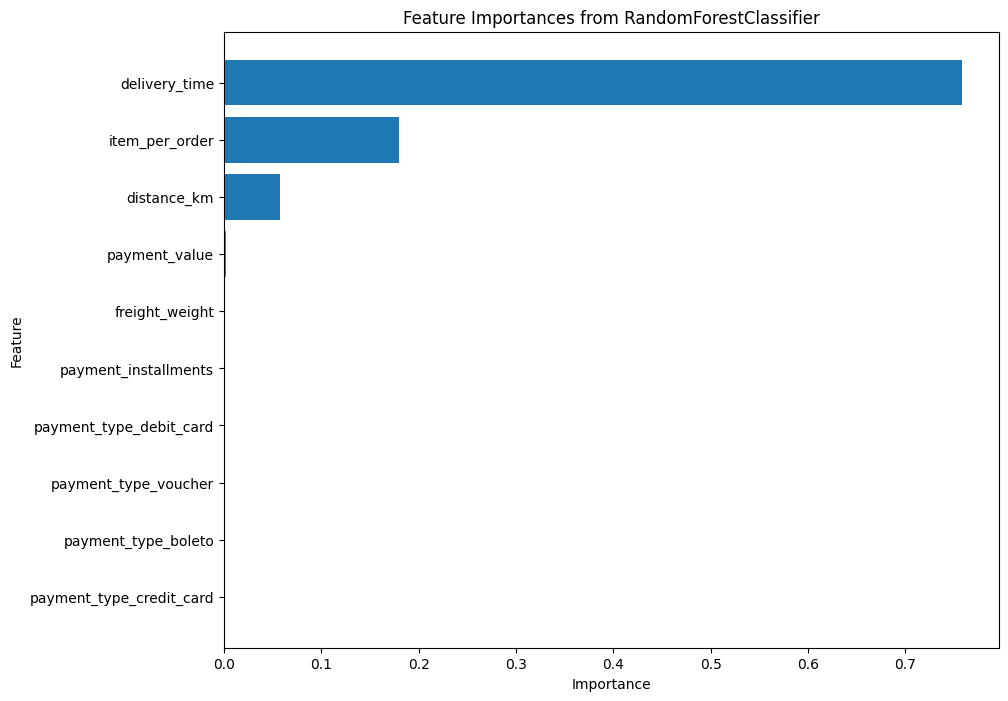

In [22]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(len(importances))]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForestClassifier')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [23]:
importance_df

,Feature,Importance
4,delivery_time,0.758070
3,item_per_order,0.179898
5,distance_km,0.057709
1,payment_value,0.002292
2,freight_weight,0.001223
0,payment_installments,0.000784
8,payment_type_debit_card,0.000008
9,payment_type_voucher,0.000006
6,payment_type_boleto,0.000006
7,payment_type_credit_card,0.000003


## Plot Tree

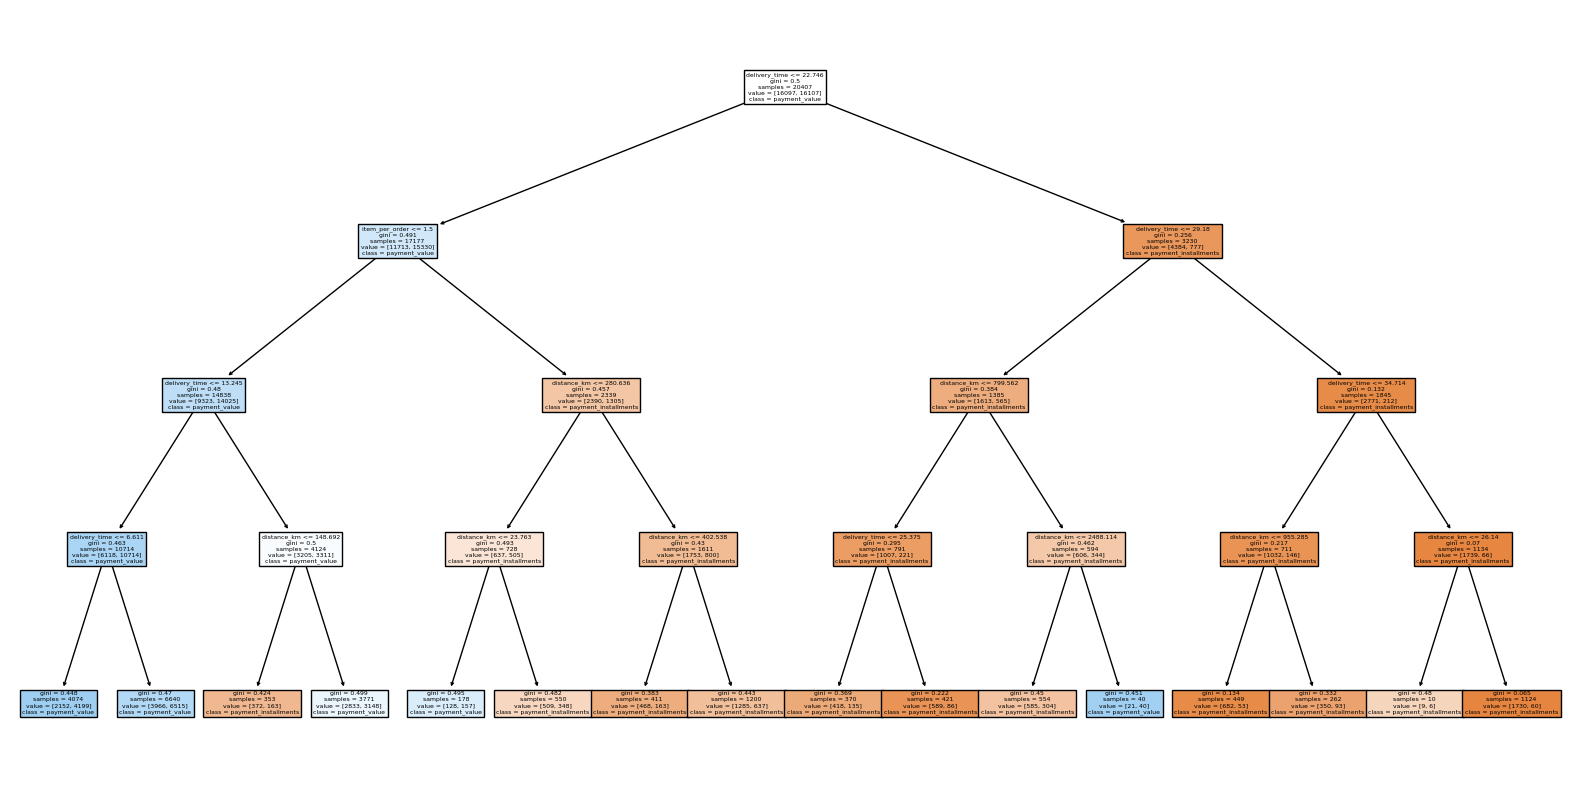

In [27]:
# Extract one tree from the forest
estimator = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=feature_names, class_names=feature_names, filled=True)
plt.show()